# About

* Formålet med denne notebooken er å utforske en pakke for å oppdage indirekte diskriminering i modeller, utviklet av Fairlearn (https://fairlearn.org/)

* Datasettet som brukes er Census fra OpenML. Dette datasettet brukes vanligvis til å predikere om en inntekt er over eller under 50.000 dollar, men i dette eksempelet vil vi bruke det som en modell for innvilgelse av lån eller ikke.

* Fremgangsmåten i grove trekk:
    - Trene en vanlig ML-modell
    - Vise at modellen diskriminerer
    - Lage en mindre diskriminerende modell ved å bruke GridSearch-algoritmen fra Fairlearn-pakken

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics as skm

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame, selection_rate, count

# Loading, preprocessing and inspecting data

In [2]:
# Loading data
census = fetch_openml(data_id=1590, as_frame=True)

In [3]:
df = census.data

In [4]:
# Recoding target to binary outcome and merge everything into a single df
df['target'] = (census.target == '>50K') * 1

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


I datasettet finnes det tre variabler som åpenbart ikke bør være med i en prediksjonsmodell som skal fungere som beslutningsstøtte for innvilgelse av lån (race, sex, native-country). Disse droppes fra modellen, men vi velger å beholde kjønn som kontrollvariabel for diskriminering. Ideelt sett burde alle vært med, men dette krever mye regnekraft og gjør at notebooken tar lang tid å kjøre. 

In [6]:
A = df['sex']
y = df['target']
X = df.drop(labels=['sex', 'race', 'native-country', 'target'], axis = 1)

In [7]:
X = pd.get_dummies(X)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
# Splitting in test and training set
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X_scaled,
                                                                     y,
                                                                     A,
                                                                     test_size=0.2,
                                                                     random_state=1234,
                                                                     stratify=y)

# Training a fairness-unaware predictor

In [9]:
unmitigated_model = RandomForestClassifier(random_state = 1234)
unmitigated_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [10]:
# Checking model fairness using Fairlearn MetricFrame
metric_frame = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                    "selection_rate": selection_rate,
                                    "count": count},
                           sensitive_features=A_test,
                           y_true=y_test,
                           y_pred=unmitigated_model.predict(X_test))

accuracy          0.850957
selection_rate    0.208414
count                 9769
dtype: object


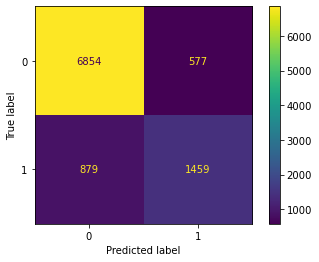

In [11]:
print(metric_frame.overall)
skm.plot_confusion_matrix(unmitigated_model, X_test,y_test)

        accuracy selection_rate count
sex                                  
Female  0.919325        0.08773  3260
Male    0.816715       0.268859  6509


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='sex'>]],
      dtype=object)

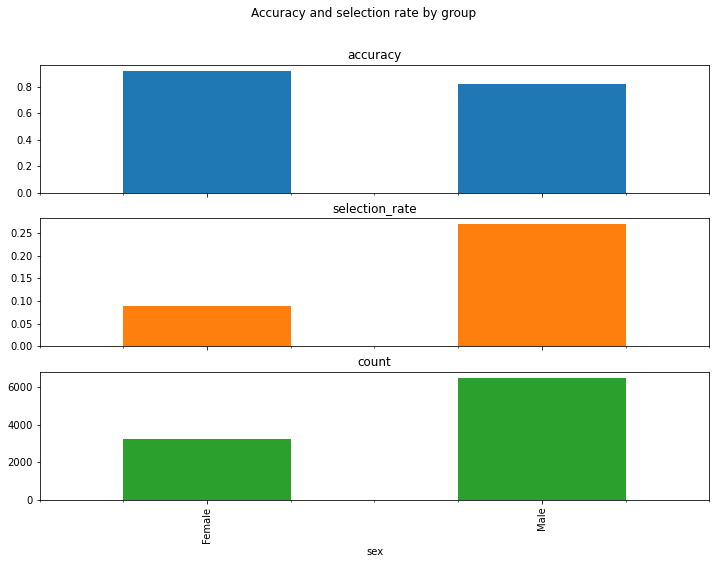

In [12]:
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
        subplots=True, layout=[3, 1], legend=False, figsize=[12, 8],
        title='Accuracy and selection rate by group')

Ser man på den demografiske forskjellen i accuracy, ser vi at menn har en større feilrate enn kvinner. Det som er mer interessant er forskjellen i muligheten for å få lån (selection rate). Her ser vi at hvis du er mann har du 3 ganger så høy mulighet for å få innvilget et lån, sammenlignet med hvis du er kvinne. 

Ut fra dette kan vi konkludere med at selv om vi ikke har med kjønn i våres modell, vil datasettet indirekte diskriminere kvinner.

# Mitigation with GridSearch

For å lage en modell som er mindre diskriminerende, spesifiserer vi at vi ønsker å bruke demografisk likhet som en rettferdighets-metrikk. Dette betyr at ved en perfekt modell vil alle individer ha lik mulighet til å få innvilget et lån, uavhengig av hvilket kjønn du er. 

GridSearch-algoritmen fungerer på samme måte som andre ML-pakker i Python hvor du har fit() og predict(). I tillegg må det spesifiseres to ekstra argumenter. Hvor mange modeller man ønsker å generere (grid_size) og hvilke variabel som er den du ønsker å måle diskriminering opp mot (sensitive_features)

In [13]:
sweep = GridSearch(RandomForestClassifier(random_state = 1234),
                  constraints = DemographicParity(),
                  grid_size = 35)

In [14]:
sweep.fit(X_train, y_train,
         sensitive_features = A_train)

predictors = sweep.predictors_

For å gjøre resultatene mer oversiktlige fjerner vi de dårligste modellene.

In [15]:
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(y_train), sensitive_features=A_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(y_train), sensitive_features=A_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Sammenligner de beste modellene fra GridSearch med den opprinnelige modellen

Text(0, 0.5, 'selection rate difference')

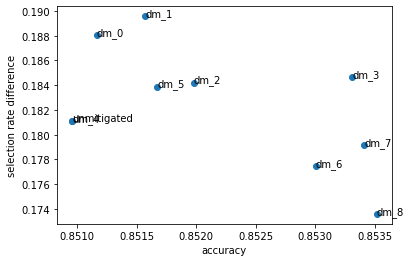

In [16]:
predictions = {"unmitigated": unmitigated_model.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dm_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=A_test,
                                     y_true=y_test,
                                     y_pred=predictions[key])

x = [metric_frame.overall['accuracy'] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()['selection_rate'] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i], y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

Ser vi på resultatene fra de ulike modellene er det 3 modeller som peker seg ut som bedre når det kommer til accuracy og selection rate difference, sammenlignet med den opprinnelige modellen (dm_6, dm_7 og dm_8). Merk at det er ekstremt små forskjeller, så endringene i resultatene vil ikke være store.

# Taking a closer look at a model

### Best accuracy and lowest selection rate difference

In [17]:
metric_frame_dm = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate,
                                        "count": count},
                               sensitive_features=A_test,
                               y_true=y_test,
                               y_pred=predictions['dm_8'])

accuracy          0.853516
selection_rate    0.202784
count                 9769
dtype: object


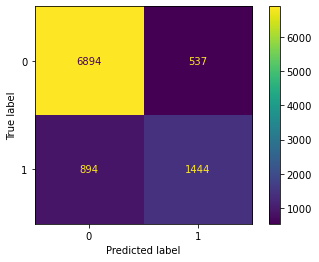

In [18]:
print(metric_frame_dm.overall)
skm.plot_confusion_matrix(non_dominated[8], X_test,y_test)

        accuracy selection_rate count
sex                                  
Female  0.922393       0.087117  3260
Male     0.81902       0.260716  6509


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='sex'>]],
      dtype=object)

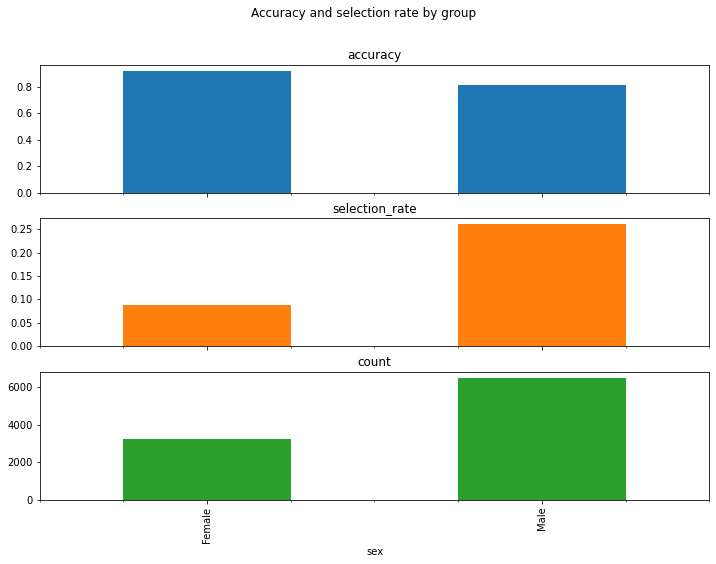

In [19]:
print(metric_frame_dm.by_group)
metric_frame_dm.by_group.plot.bar(
        subplots=True, layout=[3, 1], legend=False, figsize=[12, 8],
        title='Accuracy and selection rate by group')

Vi har i denne notebooken vist at det er mulig å oppdage indirekte diskriminering i en modell og gjøre modellen mindre diskriminerende, selv om det i dette eksempelet kun var en minimal forbedring.

Betyr dette at man alltid må rette for diskriminering? Hvis kostnaden for å ha en falsk positiv er høy enten i kroner eller omdømme vil jeg si nei. Om man skal rette og evt hvor mye dette skal gå på bekostning av treffsikkerheten til modellen er avhengig av hva modellen skal gjøre vil være en filosofisk og forretningsmessig diskusjon. Ofte vil det holde å undersøke om det finnes diskriminering, notere seg dette og forklare det med at modellen diskriminerer indirekte, men dette er pga mønster i data. 